# Learning and Decision Making

## Laboratory 1: Markov chains

In the end of the lab, you should export the notebook to a Python script (``File >> Download as >> Python (.py)``). Make sure that the resulting script includes all code written in the tasks marked as "**Activity n. N**", together with any replies to specific questions posed. Your file should be named `padi-labKK-groupXXX.py`, where `KK` corresponds to the lab number and the `XXX` corresponds to your group number. Similarly, your homework should consist of a single pdf file named `padi-hwKK-groupXXX.pdf`. You should create a zip file with the lab and homework files and submit it in Fenix **at most 30 minutes after your lab is over**.

Make sure to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.

In particular, after completing the activities you should be able to replicate the examples provided (although this, in itself, is no guarantee that the activities are correctly completed).

### 1. The Markov chain model

Consider once again the document web problem described in the Homework and for which you wrote a Markov chain model. In this lab you will interact with a larger version of the same problem. You will use a Markov chain based on a provided web of documents and investigate the relation between the PageRank algorithm and the stable behavior of the chain.

Recall that your chain should describe the motion of a bot navigating the provided document web, where, upon arriving at a document, the bot will select, uniformly at random, one of the links in that document and follow that link.

In this first activity, you will implement your Markov chain model in Python. You will start by loading the transition probability matrix from a `numpy` binary file, using the `numpy` function `load`. You will then consider the state space to consist of all valid indices for the loaded transition matrix, each represented as a string. For example, if the transition probability matrix is $20\times 20$, the states should include the strings `'0'` to `'19'`.

---

#### Activity 1.        

Write a function named `load_chain` that receives, as input, a string corresponding to the name of the file with a transition matrix to be loaded, and a real number $\gamma$ between $0$ and $1$. Assume that:

* The transition matrix in the file has been built from some web of documents, where the appropriate transitions for sink nodes have already been added.

* The "teleporting" artifact described in the course's lecture notes **has not** been added.

Your function should build the transition probability matrix for the chain by adding the teleport mechanism, where the value of $\gamma$ is the teleporting probability. Your function should then return, as output, a two-element tuple corresponding to the Markov chain, where:

* ... the first element is a tuple containing an enumeration of the state-space (i.e., each element of the tuple corresponds to a state of the chain, represented as a string);
* ... the second element is a `numpy` array corresponding to the transition probability matrix for the chain.

---

In [2]:
import numpy as np
def load_chain(filename, gamma):
    data = np.array(np.load(filename), dtype=np.float64)
    states = ()
    for i in range(data.shape[0]):
        states += (str(i),)
        norm = 1 - gamma
        data[i] = data[i] * norm
        data[i] += gamma/data[i].shape[0]
    return (states, data)

We provide below an example of application of the function with the files `example.npy` and `citations.npy`, provided in the course's webpage, that you can use as a first "sanity check" for your code. Note, however, that the fact that you can replicate the examples below is not indicative that your code is correct. Moreover, your code will be tested with networks of different sizes, so **make sure not to hard-code the size of the environments into your code**.

The file `example.npy` corresponds to the web of documents in the PageRank example from class. According to the previous specification, the transition probabilities for sink nodes have been corrected but no teleporting probabilities have been added. The file `citations.npy` corresponds to a web of connected PhD students, where there is a link between student $x$ and $y$ if the two have collaborated in a paper.

```python
print('- Small chain -')

Msmall = load_chain('example.npy', 0.11)
print('Number of states:', len(Msmall[0]))
print('Transition probabilities:')
print(Msmall[1])

import numpy.random as rand

rand.seed(42)

print('\n- Large chain -')

Mlarge = load_chain('citations.npy', 0.11)
print('Number of states:', len(Mlarge[0]))
x = rand.randint(len(Mlarge[0]))
print('Random state:', Mlarge[0][x])
print('Transition probabilities in random state:')
print(Mlarge[1][x, :])
```

Output:
```
- Small chain -
Number of states: 11
Transition probabilities:
[[0.01  0.9   0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01 ]
 [0.01  0.01  0.455 0.455 0.01  0.01  0.01  0.01  0.01  0.01  0.01 ]
 [0.01  0.455 0.01  0.01  0.01  0.01  0.01  0.455 0.01  0.01  0.01 ]
 [0.01  0.01  0.01  0.01  0.455 0.01  0.01  0.01  0.455 0.01  0.01 ]
 [0.01  0.01  0.01  0.01  0.01  0.9   0.01  0.01  0.01  0.01  0.01 ]
 [0.01  0.01  0.01  0.01  0.01  0.01  0.9   0.01  0.01  0.01  0.01 ]
 [0.01  0.01  0.01  0.01  0.455 0.455 0.01  0.01  0.01  0.01  0.01 ]
 [0.099 0.099 0.099 0.099 0.099 0.099 0.099 0.01  0.099 0.099 0.099]
 [0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.9   0.01 ]
 [0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.9   0.01  0.01 ]
 [0.01  0.01  0.01  0.01  0.01  0.01  0.9   0.01  0.01  0.01  0.01 ]]

- Large chain -
Number of states: 1883
Random state: 1126
Transition probabilities in random state:
[5.8417419e-05 5.8417419e-05 5.8417419e-05 ... 5.8417419e-05 5.8417419e-05
 5.8417419e-05]
```

We also provide an additional file, `deterministic.npy`, corresponding to a chain with only 3 nodes, that you can use for debugging purposes.

In the next activity, you will use the Markov chain model to evaluate the likelihood of any given path for the bot.

---

#### Activity 2.

Write a function `prob_trajectory` that receives, as inputs,

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a trajectory, corresponding to a sequence of states (i.e., a tuple or list of strings, each string corresponding to a state).

Your function should return, as output, a floating point number corresponding to the probability of observing the provided trajectory, taking the first state in the trajectory as initial state.  

---

In [4]:
def prob_trajectory(mc, trajectory):
    prob = 1
    for i in range(len(trajectory)-1):
        prob *= mc[1][int(trajectory[i]), int(trajectory[i+1])]

    return prob

- Chain from "example.npy" -
Prob. of trajectory 1-3-8: 0.20702500000000001
Prob. of trajectory 2-7-0-1-3: 0.0184459275
Prob. of trajectory 1-2-1: 0.20702500000000001
Prob. of trajectory 1-3-1: 0.00455

- Chain from "citations.npy" -
Prob. of trajectory 1-3-8: 3.4125948440486464e-09
Prob. of trajectory 2-7-0-1-3: 1.0592100803408243e-16
Prob. of trajectory 1-2-1: 0.19808999279124595
Prob. of trajectory 1-3-1: 3.4125948440486464e-09


Example of application of the function with the chain $M$ from Activity 1 (PageRank example in class).

```python
print('- Chain from "example.npy" -')
print("Prob. of trajectory 1-3-8:", prob_trajectory(Msmall, ('1', '3', '8')))
print("Prob. of trajectory 2-7-0-1-3:", prob_trajectory(Msmall, ('2', '7', '0', '1', '3')))
print("Prob. of trajectory 1-2-1:", prob_trajectory(Msmall, ('1', '2', '1')))
print("Prob. of trajectory 1-3-1:", prob_trajectory(Msmall, ('1', '3', '1')))

print('\n- Chain from "citations.npy" -')

print("Prob. of trajectory 1-3-8:", prob_trajectory(Mlarge, ('1', '3', '8')))
print("Prob. of trajectory 2-7-0-1-3:", prob_trajectory(Mlarge, ('2', '7', '0', '1', '3')))
print("Prob. of trajectory 1-2-1:", prob_trajectory(Mlarge, ('1', '2', '1')))
print("Prob. of trajectory 1-3-1:", prob_trajectory(Mlarge, ('1', '3', '1')))
```

Output:
```
- Chain from "example.npy" -
Prob. of trajectory 1-3-8: 0.20702500000000001
Prob. of trajectory 2-7-0-1-3: 0.0184459275
Prob. of trajectory 1-2-1: 0.20702500000000001
Prob. of trajectory 1-3-1: 0.00455

- Chain from "citations.npy" -
Prob. of trajectory 1-3-8: 3.4125948440486464e-09
Prob. of trajectory 2-7-0-1-3: 1.0592100803408243e-16
Prob. of trajectory 1-2-1: 0.19808999279124595
Prob. of trajectory 1-3-1: 3.4125948440486464e-09
```

Note that your function should work with **any** Markov chain that is specified as a tuple like the one from Activity 1.

### 2. Stability

The next activities explore the notion of *stationary distribution* for the chain, a central concept in the PageRank algorithm.

---

#### Activity 3

Write a function `stationary_dist` that receives, as input, a Markov chain in the form of a tuple like the one returned by the function in Activity 1. Your function should return, as output, a `numpy` array corresponding to a row vector containing the stationary distribution for the chain.

**Note:** The stationary distribution is a *left* eigenvector of the transition probability matrix associated to the eigenvalue 1. As such, you may find useful the numpy function `numpy.linalg.eig`. Also, recall that the stationary distribution is *a distribution*. You may also find useful the function `numpy.real` which returns the real part of a complex number.

---

In [25]:
import numpy as np

def stationary_dist(mc):
    eigenvalues, eigenvectors = np.linalg.eig(mc[1].T)
    for i in range(len(eigenvalues)):
        if np.isclose(eigenvalues[i], 1.0):
            return np.real(eigenvectors[:, i].T/np.sum(eigenvectors[:, i].T))



Example of application of the function with the chain $M$ from Activity 1.

```python
print('- Chain from "example.npy" -')
u_star = stationary_dist(Msmall)

print('Stationary distribution:')
print(np.round(u_star, 2))

u_prime = u_star.dot(Msmall[1])

print('\nIs u* * P = u*?', np.all(np.isclose(u_prime, u_star)))

print('\n- Chain from "citations.npy" -')
u_star = stationary_dist(Mlarge)

print('Is this a distribution?', np.isclose(np.sum(u_star), 1))

print('Most likely state:', Mlarge[0][np.argmax(u_star)])

u_prime = u_star.dot(Mlarge[1])

print('\nIs u* * P = u*?', np.all(np.isclose(u_prime, u_star)))
```

Output:
```
- Chain from "example.npy" -
Stationary distribution:
[[0.01 0.03 0.03 0.03 0.12 0.21 0.21 0.02 0.17 0.16 0.01]]

Is u* * P = u*? True

- Chain from "citations.npy" -
Is this a distribution? True
Most likely state: 216

Is u* * P = u*? True
```

To complement Activity 3, you will now empirically establish that the chain is ergodic, i.e., no matter where the bot starts, its visitation frequency will eventually converge to the stationary distribution.

---

#### Activity 4.

Write a function `compute_dist` that receives, as inputs,

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a row vector (a numpy array) corresponding to the initial distribution for the chain;
* ... an integer $N$, corresponding to the number of steps that the chain is expected to take.

Your function should return, as output, a row vector (a `numpy` array) containing the distribution after $N$ steps of the chain. Use your function to justify that the chain is ergodic.

---

In [28]:
import numpy.random as rnd

def compute_dist(M_Chain, mu_0, N):
    return mu_0 @ np.linalg.matrix_power(M_Chain[1], N)

- Chain from "example.npy" -

- Repetition 1 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 2 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 3 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 4 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 5 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True


Since every has the teleport property, it can go from every state to every state and thus is irreductible and aperiodic. Also, the sinks have links to every other state, so they can transition to every state.

If a chain is irreductible and aperiodic with stationary distribution u*, and for a certain t-> inf, lim u_0 P^t = u*,
with u_0 being the initial distribution, then it is an ergodic chain.

The function compute_dist allows us to compute u_0 * P^t, and since we already know that all chains loaded by load_function are irreductible and aperiodic, if we verify that the result of compute_dist equals u*, we can verify if the chain is ergodic.

Since for the chains given, u* P^2000 = u*, we can prove the chains are ergodic.

Example of application of the function with the chain $M$ from Activity 1.

```python
import numpy.random as rnd

rnd.seed(42)

REPETITIONS = 5

print('- Chain from "example.npy" -')

# Number of states
nS = len(Msmall[0])
u_star = stationary_dist(Msmall)

# Repeat a number of times
for n in range(REPETITIONS):
    
    print('\n- Repetition', n + 1, 'of', REPETITIONS, '-')
    
    # Initial random distribution
    u = rnd.random((1, nS))
    u = u / np.sum(u)

    # Distrbution after 10 steps
    v = compute_dist(Msmall, u, 10)
    print('Is u * P^100 = u*?', np.all(np.isclose(v, u_star)))

    # Distrbution after 100 steps
    v = compute_dist(Msmall, u, 100)
    print('Is u * P^2000 = u*?', np.all(np.isclose(v, u_star)))
    
print('\n- Chain from "citations.npy" -')

# Number of states
nS = len(Mlarge[0])
u_star = stationary_dist(Mlarge)

# Repeat a number of times
for n in range(REPETITIONS):
    
    print('\n- Repetition', n + 1, 'of', REPETITIONS, '-')
    
    # Initial random distribution
    u = rnd.random((1, nS))
    u = u / np.sum(u)

    # Distrbution after 100 steps
    v = compute_dist(Mlarge, u, 100)
    print('Is u * P^100 = u*?', np.all(np.isclose(v, u_star)))

    # Distrbution after 2000 steps
    v = compute_dist(Mlarge, u, 2000)
    print('Is u * P^2000 = u*?', np.all(np.isclose(v, u_star)))
```

Output:
````
- Chain from "example.npy" -

- Repetition 1 of 5 -
Is u * P^100 = u*? False
Is u * P^2000 = u*? True

- Repetition 2 of 5 -
Is u * P^100 = u*? False
Is u * P^2000 = u*? True

- Repetition 3 of 5 -
Is u * P^100 = u*? False
Is u * P^2000 = u*? True

- Repetition 4 of 5 -
Is u * P^100 = u*? False
Is u * P^2000 = u*? True

- Repetition 5 of 5 -
Is u * P^100 = u*? False
Is u * P^2000 = u*? True

- Chain from "citations.npy" -

- Repetition 1 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 2 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 3 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 4 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True

- Repetition 5 of 5 -
Is u * P^100 = u*? True
Is u * P^2000 = u*? True
```

### 3. Simulation

In this part of the lab, you will *simulate* the actual bot, and empirically compute the visitation frequency of each state.

---

#### Activity 5

Write down a function `simulate` that receives, as inputs,

* ... a Markov chain in the form of a tuple like the one returned by the function in Activity 1;
* ... a row vector (a `numpy` array) corresponding to the initial distribution for the chain;
* ... an integer $N$, corresponding to the number of steps that the chain is expected to take.

Your function should return, as output, a tuple containing a trajectory with $N$ states, where the initial state is sampled according to the initial distribution provided. Each element in the tuple should be a string corresponding to a state index.

---

**Note:** You may find useful to import the numpy module `numpy.random`.

In [37]:
import numpy.random as rnd

def simulate(mc, init_dist, N):
    initial_state = rnd.choice(mc[0], p=init_dist[0])
    trajectory = (initial_state,)
    for step in range(1, N):
        trajectory += (rnd.choice(mc[0], p=mc[1][int(trajectory[step-1])]),)

    return trajectory

Example of application of the function with the chain $M$ from Activity 1.

```python
import numpy.random as rnd

rnd.seed(42)

print('- Chain from "example.npy" -')

# Number of states
nS = len(Msmall[0])

# Initial, uniform distribution
u = np.ones((1, nS)) / nS

# Simulate short trajectory
traj = simulate(Msmall, u, 10)
print('Small trajectory:', traj)

# Simulate a long trajectory
traj = simulate(Msmall, u, 10000)
print('End of large trajectory:', traj[-10:])

print('\n- Chain from "citations.npy" -')

# Number of states
nS = len(Mlarge[0])

# Initial, uniform distribution
u = np.ones((1, nS)) / nS

# Simulate short trajectory
traj = simulate(Mlarge, u, 10)
print('Small trajectory:', traj)

# Simulate a long trajectory
traj = simulate(Mlarge, u, 10000)
print('End of large trajectory:', traj[-10:])
```

Output:
```
- Chain from "example.npy" -
Small trajectory: ('4', '6', '5', '6', '4', '5', '5', '6', '5', '6')
End of large trajectory: ('9', '8', '9', '8', '9', '8', '3', '8', '9', '8')

- Chain from "citations.npy" -
Small trajectory: ('1668', '1667', '1668', '1667', '996', '241', '119', '6', '119', '6')
End of large trajectory: ('623', '175', '174', '175', '456', '455', '1112', '1406', '1523', '1406')
```

Note that, even if the seed is fixed, it is possible that your trajectories are slightly different.

---

#### Activity 6

Use the function `simulate` from Activity #5 to generate a 50,000-step trajectory in the chain obtained from `example.npy` using a uniform distribution as initial distribution. Plot the histogram of the obtained trajectory using the function `hist` from the module `matplotlib.pyplot`. Make sure that the histogram has one bin for each state. Compare the relative frequencies with the result of Activity #3, plotting the latter on top of the histogram.

**Note**: Don't forget to load `matplotlib`.

**Note 2**: Recall that the states in the trajectory obtained from the function `simulate` consist of *strings*, which should be converted to state indices to match the entries in the distribution computed in Activity #3.

---

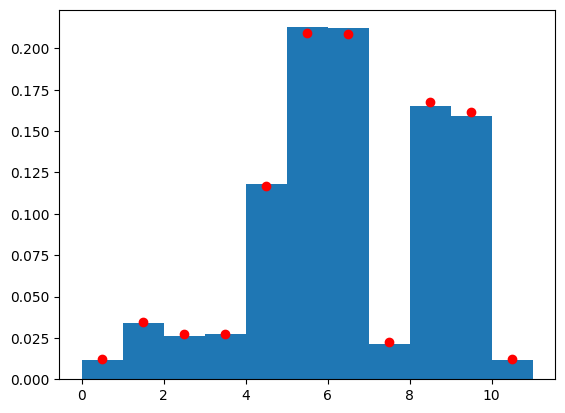

In [46]:
# Add your code here.

import matplotlib.pyplot as plt

chain = load_chain("example.npy", 0.11)

mu_0 = np.ones(shape=(1,len(chain[0])))/len(chain[0]) # uniform distribution

path = simulate(chain, mu_0, 50000)

path =  np.array(np.sort(path), dtype=np.int64)

plt.hist(path, bins=[x for x in range(len(chain[0])+1)], density=True)
plt.plot([x + 0.5 for x in range(len(chain[0]))], stationary_dist(chain), 'ro')

plt.show()
